In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

file = '/content/drive/MyDrive/DataScience/project/no_additional_features.zip (Unzipped Files)/train_set_interpolation_with_constant.csv'
df = pd.read_csv(file)
y_train = df['SepsisLabel']
X_train = df.drop('SepsisLabel',axis=1)



In [ ]:
file = '/content/drive/MyDrive/DataScience/project/no_additional_features.zip (Unzipped Files)/val_set_interpolation_with_constant.csv'
df = pd.read_csv(file)
y_val = df['SepsisLabel']
X_val = df.drop('SepsisLabel',axis=1)

In [ ]:
file = '/content/drive/MyDrive/DataScience/project/no_additional_features.zip (Unzipped Files)/test_set_interpolation_with_constant.csv'
df = pd.read_csv(file)
y_test = df['SepsisLabel']
X_test = df.drop('SepsisLabel',axis=1)

In [ ]:
# evaluate xgboost algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

# define the model
model = XGBClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.984 (0.000)


In [ ]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score
f1_score = f1_score(y_test,y_pred,average = None)

In [ ]:
print(f1_score)

[4.75880776e-05 2.36657064e-02]


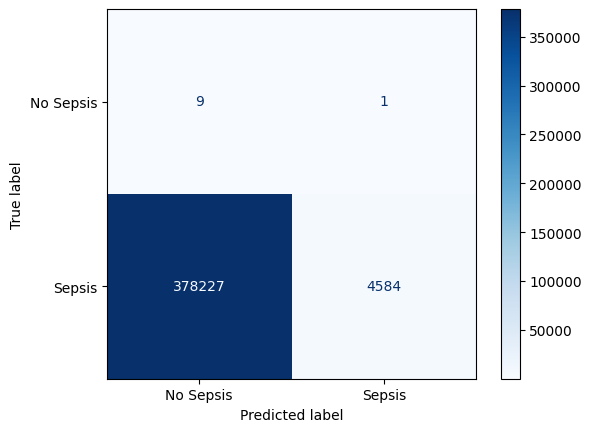

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


CM = confusion_matrix(y_pred,y_test)
ConfusionMatrixDisplay.from_predictions(y_pred, y_test, display_labels=['No Sepsis','Sepsis'], cmap='Blues')
plt.show()


# Break

In [ ]:
# focus just on patients who develop sepsis
# All sepsis patients
septic_list = df['Patient_ID'][df['SepsisLabel']==1].unique()
septic_df  = df[df.Patient_ID.isin(septic_list)]

# Admitted with sepsis
admitted_with_sepsis_list = df['Patient_ID'][(df['SepsisLabel']==1) & (df['Hour']==0)].unique()

# Develop sepsis
mask = ~septic_df['Patient_ID'].isin(admitted_with_sepsis_list) # boolean mask
developed_sepsis_df = septic_df[mask]
developed_sepsis_df = developed_sepsis_df.drop('Unnamed: 0', axis=1)

# Remove features that are missing completely in over 50% of patients
# Group the DataFrame by the ID column
grouped_by_ID = developed_sepsis_df.groupby('Patient_ID')

# Calculate the number of times each feature takes all NaN values for each ID
no_patient_data = grouped_by_ID.apply(lambda x: x.isna().all()).sum().drop('Patient_ID')

# expressed as percentage
no_patient_data = no_patient_data/developed_sepsis_df['Patient_ID'].nunique()

# remove any features that arent available for over 70% of patients
tol = 0.5
list_of_sparse_features = no_patient_data.loc[no_patient_data > tol].index.tolist()

print(list_of_sparse_features)

# create new dataframe without the sparse features 
reduced_features = developed_sepsis_df.drop(columns = list_of_sparse_features)

['EtCO2', 'SaO2', 'Bilirubin_direct', 'TroponinI', 'Fibrinogen', 'Unit1', 'Unit2']


In [ ]:
# Group dataframe by patient id
constant = 0
by_patient = reduced_features.groupby('Patient_ID')

fragments = []
for ID, features in by_patient:

  # create list of the features for differntial and sliding window analysis
  excluded = ['Patient_ID','SepsisLabel','ICULOS','HospAdmTime','Gender','Age']
  differential_list =  features.columns.difference(excluded).tolist()

  original_features = features.columns.tolist()

  # iterate through features
  for feat in original_features:
     # For all values prior to a first measurement, assign as constant.   
    if features[feat].first_valid_index() == None:
      # Assigns columns that are nan for all time as 0
      features.loc[features.index.values.tolist()[0]:features[feat].first_valid_index(),feat] = constant
    elif features[feat].first_valid_index() == features.index.values.tolist()[0]:
      continue
    else:
      # avoids overwritting first entry as 0
      features.loc[features.index.values.tolist()[0]:features[feat].first_valid_index()-1,feat] = constant

    # For all remaining nans, foward fill
    features.ffill(inplace=True)

    # Add new columns for differential features and sliding window
    if feat in differential_list:

      # differential feature: Looks at difference between that reading and the prev hour.
      features['d'+feat] = features[feat] - features[feat].shift(1)

      # rolling statistics: Looks back at prev 6 hours
      rolling_mean = features[feat].rolling(6, min_periods = 1).mean()
      rolling_max = features[feat].rolling(6, min_periods = 1).max()
      rolling_std = features[feat].rolling(6, min_periods = 1).std()
      rolling_min = features[feat].rolling(6, min_periods = 1).min()
      
      # adds rolling stats columns 
      features[f'{feat}_mean'] = rolling_mean
      features[f'{feat}_std'] = rolling_std
      features[f'{feat}_max'] = rolling_max
      features[f'{feat}_min'] = rolling_min 

  
  # add the grouped dataframe to a list
  fragments.append(features)
  

# combine patients to get full dataframe 
filled_df = pd.concat(fragments)

In [ ]:
# fill the hour 1 values that are nan due to no differntial stats available
filled_df.fillna(value=0,inplace=True)

# check dataframe shape
print(filled_df.shape)

(103196, 181)


In [ ]:


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# summarize the dataset
print(X.shape, y.shape)

(103196, 180) (103196,)


In [ ]:
# evaluate xgboost algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

# define the model
model = XGBClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


Accuracy: 0.915 (0.002)


In [ ]:
model.fit(X_train,y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score
f1_score = f1_score(y_test,y_pred,average = None)

In [ ]:
print(f1_score)

[0.9526496  0.63714586]


In [ ]:
model.save_model('/content/drive/MyDrive/DataScience/project/XGBoostModel.h5')

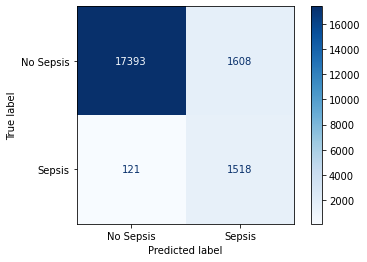

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


CM = confusion_matrix(y_pred,y_test)
ConfusionMatrixDisplay.from_predictions(y_pred, y_test, display_labels=['No Sepsis','Sepsis'], cmap='Blues')
plt.show()


In [ ]:
CM = confusion_matrix(y_pred,y_test)
print(CM)

[[17393  1608]
 [  121  1518]]


In [ ]:
model.load_model('/content/drive/MyDrive/DataScience/project/XGBoostModel.h5')